In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)


from markov_pyactup import *
from statsmodels.formula.api import logit, glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


main_dir = os.path.dirname(os.getcwd())
subject_dir = os.path.join(main_dir, 'data', 'human', 'online_data')
opt_dir = os.path.join(main_dir, 'data', 'model', 'param_optimization_0323')

main_dir, subject_dir, opt_dir

Error trying to connect to ACT-R at 127.0.0.1 : 2650 with exception (<class 'ConnectionRefusedError'>, ConnectionRefusedError(61, 'Connection refused'), <traceback object at 0x7f92050ec400>)
ACT-R connection NOT established, but no exception detected or already handled.
Could not start ACT-R connection.


('/Users/cheryang/Documents/GitProject/ACTR-MarkovTask',
 '/Users/cheryang/Documents/GitProject/ACTR-MarkovTask/data/human/online_data',
 '/Users/cheryang/Documents/GitProject/ACTR-MarkovTask/data/model/param_optimization_0323')

{'alpha': 0.1454,
 'beta': 5.0,
 'beta_mb': 3.6013,
 'beta_mf': 10.0,
 'decay': 0.8537,
 'estimate_model': 'markov-ibl-hybrid',
 'fixed_cost': 0.0,
 'lambda_parameter': 0.1206,
 'lf': 0.5,
 'maxLL': -107.4395,
 'p_parameter': 0.0,
 'subject_id': 1,
 'temperature': 0.01}


  0%|          | 0/50 [00:00<?, ?it/s]

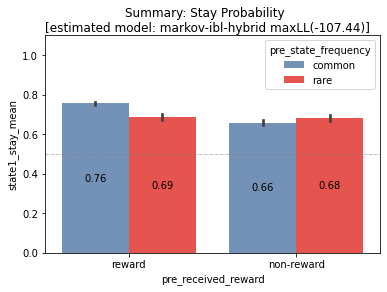

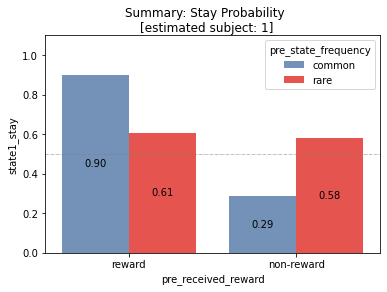

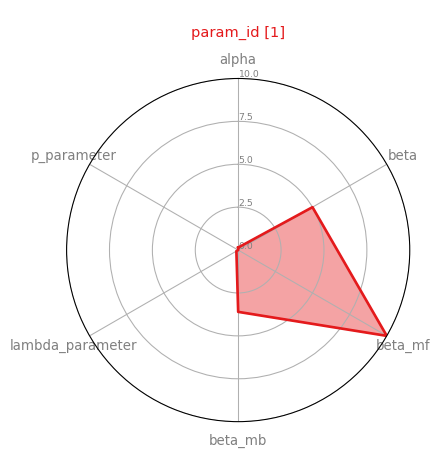

In [13]:
estimate_model = 'markov-ibl-hybrid'
subject_id = '1'


d, params = MarkovEstimation.load_opt_parameters(opt_dir=opt_dir, subject_id=subject_id, estimate_model=estimate_model)
pprint.pprint(d) 
dfe = MarkovSimulation.run_simulations(model=d['estimate_model'], e=50, verbose=False, **params)
dfs = MarkovEstimation.load_subject_data(subject_dir=subject_dir, subject_id=subject_id)

Plot.plot_response_switch(dfe, model_name='estimated model: %s maxLL(%.2f)'%(d['estimate_model'], d['maxLL']), dep_var_suffix='_mean', barplot=1)
Plot.plot_response_switch(dfs, model_name='estimated subject: %s' % (d['subject_id']), dep_var_suffix='', barplot=1)
Plot.plot_parameter_radar(df = pd.DataFrame({**params, 'group':d['subject_id']}, index=[0]), title='')

{'alpha': 0.1109,
 'beta': 25.9714,
 'beta_mb': 13.7911,
 'beta_mf': 20.3738,
 'decay': 0.5,
 'estimate_model': 'markov-rl-hybrid',
 'fixed_cost': 0.0,
 'lambda_parameter': 0.1089,
 'lf': 0.5,
 'maxLL': -106.4961,
 'p_parameter': 5.399,
 'subject_id': 1,
 'temperature': 0.2}
{'alpha': 0.5,
 'beta': 25.9714,
 'beta_mb': 5,
 'beta_mf': 20.3738,
 'lambda_parameter': 0.1089,
 'p_parameter': -1}


  0%|          | 0/1 [00:00<?, ?it/s]

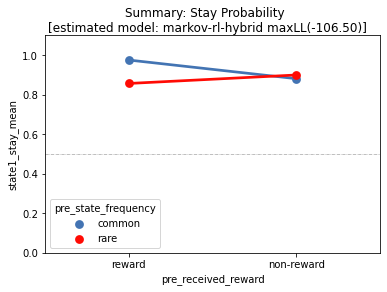

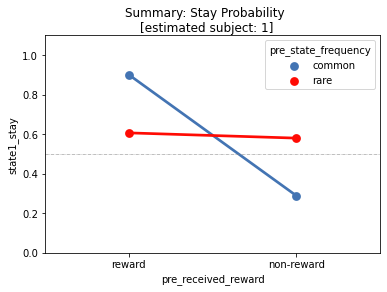

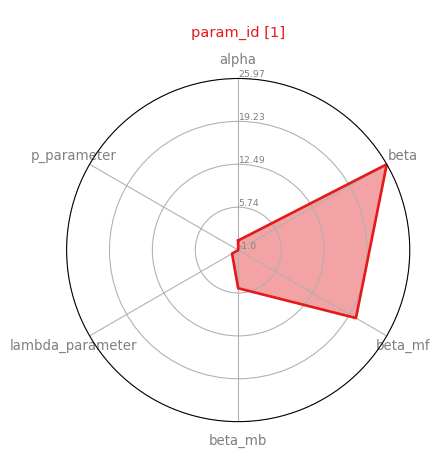

In [3]:
estimate_model = 'markov-rl-hybrid'
subject_id = '1'


d, params = MarkovEstimation.load_opt_parameters(opt_dir=opt_dir, subject_id=subject_id, estimate_model=estimate_model)
pprint.pprint(d)

params['alpha'] = .5
params['beta_mb'] = 5
# params['beta_mf'] = 5 
params['p_parameter'] = -1
pprint.pprint(params)


dfe = MarkovSimulation.run_simulations(model=d['estimate_model'], e=1, verbose=False, **params)
dfs = MarkovEstimation.load_subject_data(subject_dir=subject_dir, subject_id=subject_id)

Plot.plot_response_switch(dfe, model_name='estimated model: %s maxLL(%.2f)'%(d['estimate_model'], d['maxLL']), dep_var_suffix='_mean', barplot=0)
Plot.plot_response_switch(dfs, model_name='estimated subject: %s' % (d['subject_id']), dep_var_suffix='', barplot=False)
Plot.plot_parameter_radar(df = pd.DataFrame({**params, 'group':d['subject_id']}, index=[0]), title='')

## Correlation of `alpha`

Next, let's look at whether two alpha is correlated in two hybrid models. 

We found alpha, bet_mf, lambda, p are significantly correlated between two models

In [4]:
def load_optimization_data(opt_dir, estimate_models=None, only_maxLL=True):
    if estimate_models is None:
        estimate_models = ['markov-rl-mf',
                            'markov-rl-mb',
                            'markov-rl-hybrid', 
                            'markov-ibl-mb', 
                            'markov-ibl-hybrid']
    ls = []
    for i in np.arange(1, 152):
        for estimate_model in estimate_models: 
            try:
                if only_maxLL:
                    d, _ = MarkovEstimation.load_opt_parameters(opt_dir=opt_dir, subject_id=str(i), estimate_model=estimate_model, only_maxLL=True) 
                    df = pd.Series(d)
                else:
                    df = MarkovEstimation.load_opt_parameters(opt_dir=opt_dir, subject_id=str(i), estimate_model=estimate_model, only_maxLL=False) 
                ls.append(df)  
            except:
                print('Unable to find SUB - %s' % i)
    if only_maxLL:
        df = pd.DataFrame(ls)
    else:
        df = pd.concat(ls, axis=0)
    return df

In [5]:
# df = load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-rl-hybrid'])

In [6]:
df1 = load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-rl-hybrid']).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value')
df2 = load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-ibl-hybrid']).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value')
dfm = pd.merge(df1.drop(columns=['estimate_model']), df2.drop(columns=['estimate_model']), on=['subject_id', 'param_name'], suffixes=('.rl', '.ibl'))
dfm.head()

Cannot find file
Unable to find SUB - 20
Cannot find file
Unable to find SUB - 21
Cannot find file
Unable to find SUB - 22
Cannot find file
Unable to find SUB - 23
Cannot find file
Unable to find SUB - 24
Cannot find file
Unable to find SUB - 25
Cannot find file
Unable to find SUB - 26
Cannot find file
Unable to find SUB - 27
Cannot find file
Unable to find SUB - 28
Cannot find file
Unable to find SUB - 29
Cannot find file
Unable to find SUB - 30
Cannot find file
Unable to find SUB - 31
Cannot find file
Unable to find SUB - 51
Cannot find file
Unable to find SUB - 52
Cannot find file
Unable to find SUB - 53
Cannot find file
Unable to find SUB - 54
Cannot find file
Unable to find SUB - 55
Cannot find file
Unable to find SUB - 56
Cannot find file
Unable to find SUB - 57
Cannot find file
Unable to find SUB - 58
Cannot find file
Unable to find SUB - 59
Cannot find file
Unable to find SUB - 60
Cannot find file
Unable to find SUB - 61
Cannot find file
Unable to find SUB - 82
Cannot find file

,subject_id,param_name,param_value.rl,param_value.ibl
0,1,alpha,0.1109,0.1281
1,2,alpha,0.3489,0.4399
2,3,alpha,0.5953,0.7685
3,4,alpha,0.8619,0.1776
4,5,alpha,0.0384,0.0228


In [7]:
print( 'NUM SUBJ [%d]' % (len(dfm['subject_id'].unique())))

NUM SUBJ [95]


In [13]:
def annotate(data, **kws): 
    x, y = kws['x'], kws['y']
    r, p = stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    minx, miny, maxx, maxy = data[x].min(), data[y].min(), data[x].max(), data[y].max()
    ax.text(0.05, 0.05, 'r = %.2f (p=%.2g, %s)' % (r, p, sig(p)), transform=ax.transAxes)
    # ax.text(.05, 0.7, 'x: [%.2f - %.2f], y: [%.2f - %.2f]' % (min1, max1, min2, max2), 
    #         transform=ax.transAxes)
    
def sig(p):
    sig = ''
    if p > .05:
        sig = 'ns'
    if p <= .05:
        sig = '*'
    if p < .01:
        sig = '**'
    if p < .001:
        sig = '***'
    return sig

def param_lm_plot(df, x_name, y_name, exclude_parameters=None, alpha=.1):
    if exclude_parameters:
         df = df[~df['param_name'].isin(exclude_parameters)]
    g = sns.lmplot(data=df, x=x_name, y=y_name,  
               col="param_name", col_wrap=3, hue="param_name",  
               height=3, aspect=1.2, palette='Set1', 
               scatter_kws={'alpha':alpha}, 
               facet_kws=dict(sharex=False, sharey=False))
    g.map_dataframe(annotate, x=x_name, y=y_name)
    g.fig.subplots_adjust(top=.9) # adjust the Figure in rp
    g.fig.suptitle('Correlation of optimizated parmeters [%s] vs. [%s]: ' % (x_name, y_name))
    plt.show()

/opt/anaconda3/envs/pyactr/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


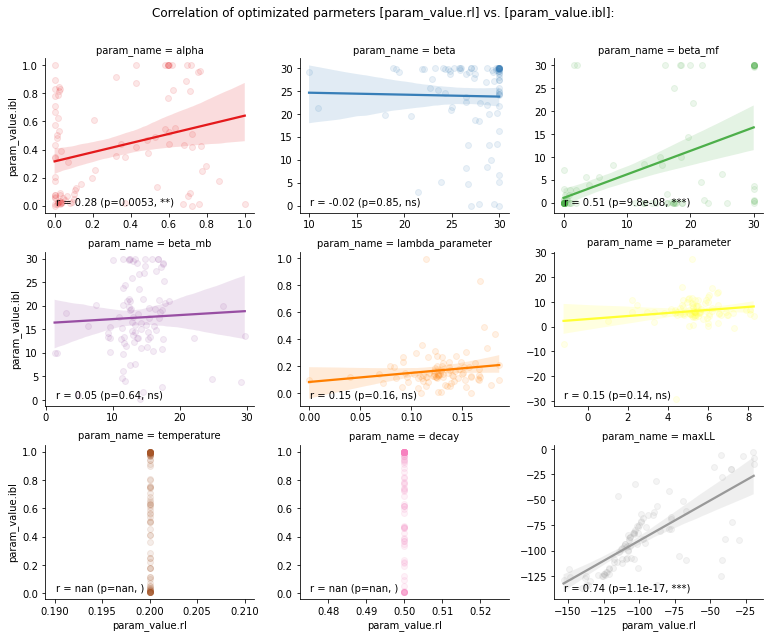

In [14]:
param_lm_plot(df=dfm, x_name="param_value.rl", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost'])

## Correlation of Alpha and Age

In [15]:
dfa = pd.read_csv(os.path.join(subject_dir, 'mbmf_ages.csv'))
dfa['subject_id'] = dfa['subject_id'].apply(lambda x: int(x[3:]))

dfa = pd.merge(dfm, dfa, on='subject_id', how='left') 

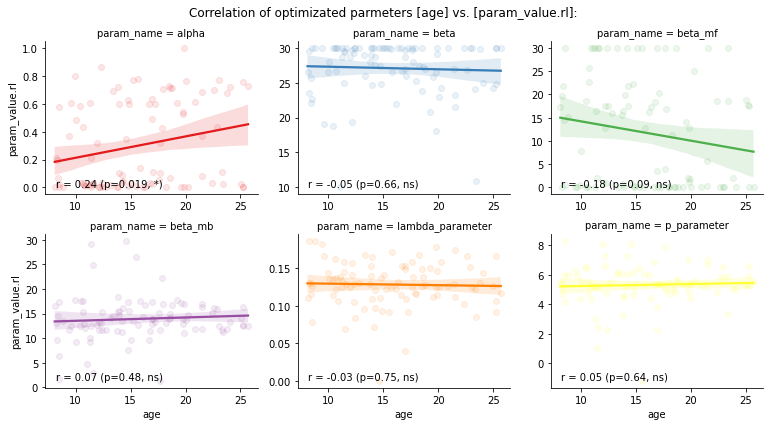

In [16]:
param_lm_plot(df=dfa, x_name="age", y_name="param_value.rl", exclude_parameters=['decay', 'temperature', 'lf', 'fixed_cost', 'maxLL'])

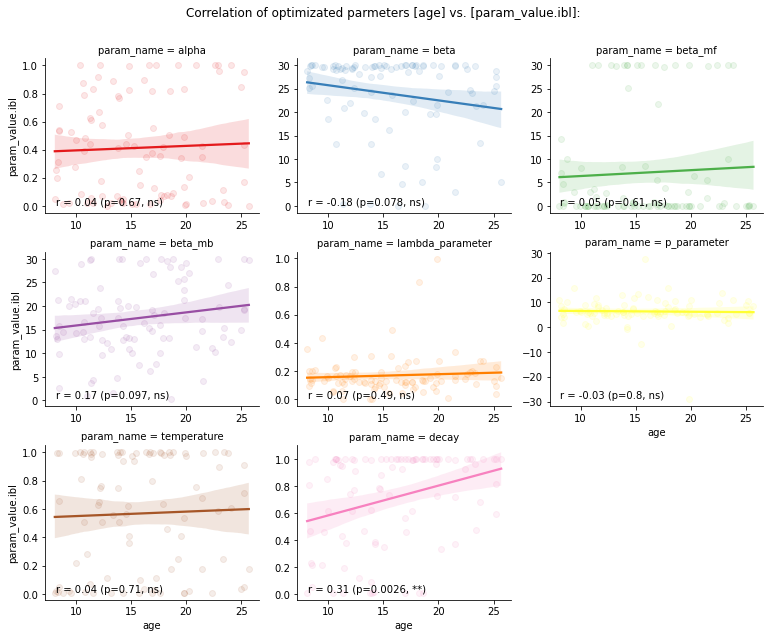

In [17]:
param_lm_plot(df=dfa, x_name="age", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost', 'maxLL'])